# 1D Coalescent Hitting Times

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from fenics import *
import product_fem as pf
from IPython.display import Video

In [2]:
# helpful functions
def plot_u(u, W, title=None):
    n = W.V.dim()
    V_coords = W.dofmap.marginal_dof_coords
    X, Y = np.meshgrid(V_coords, V_coords, indexing='ij')
    Z = u.as_matrix()

    fig, ax = plt.subplots(figsize=(6,6))
    a = ax.contourf(X, Y, Z, levels=8)
    ax.set_aspect('equal')
    if title: ax.set_title(title, fontsize=15)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(a, cax=cax, orientation='vertical')
    plt.show()
    
def plot_m(m, W, labels=[r'$\mu(x)$', r'$\sigma(x)$']):
    V_coords = W.dofmap.marginal_dof_coords
    fig, ax = plt.subplots()
    for i, mi in enumerate(m):
        mi = mi.vector()[:]
        if labels: ax.plot(V_coords, mi, label=labels[i])
        else: ax.plot(V_coords, mi)
    if labels: plt.legend()
    ax.set_xlabel(r'x')
    plt.show()

### Forward pass inspection

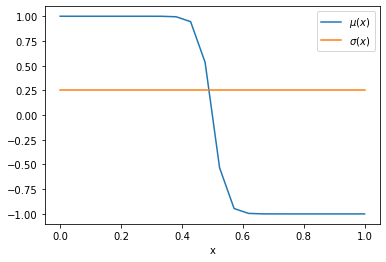

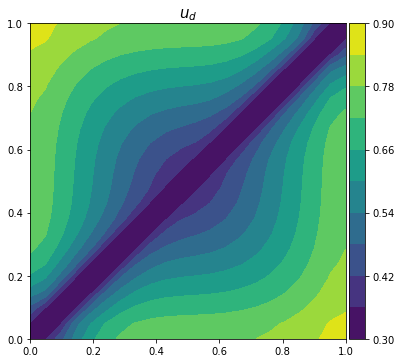

In [3]:
# mesh and function spaces
n = 22 # mesh resolution
mesh = UnitIntervalMesh(n-1)
V = FunctionSpace(mesh, 'CG', 1)
V_coords = V.tabulate_dof_coordinates()
W = pf.ProductFunctionSpace(V)

# generate ground truth data u_d
eqn = pf.HittingTimes(W, 0.35, 0.065)
mu_true = pf.to_Function('-2 / (1 + exp(-50 * (x[0] - 0.5))) + 1', V)
sig_true = pf.to_Function('0.25', V)
m = eqn.control
m.update([mu_true, sig_true])
u_d = eqn.solve(m)

plot_m(m, W)
plot_u(u_d, W, title=r'$u_d$')

In [4]:
reg = {'l2': [1e-4, 1e-4], 'smoothing': [1e-5, 1e-4]}
loss = pf.LossFunctional(u_d, m, reg)
invp = pf.InverseProblem(eqn, loss)

In [5]:
mu_dim = m[0].function_space().dim()
sig_dim = m[1].function_space().dim()
mu0 = np.zeros(mu_dim)
sig0 = 0.5 * np.ones(sig_dim)
m.update([mu0, sig0])
ms, results = invp.optimize(m, method='L-BFGS-B', options={'maxcor': 25})

0.0042232306066814496
0.0040965922145903754
0.003887266256755408
0.003467093758439646
0.003259502224234036
0.003229011579036833
0.0031704322020613285
0.003076389245697749
0.0029811357055021977
0.0027942047695185958
0.002720050088209468
0.0026971590431522164
0.002634015693549002
0.0023612751974632475
0.0021428583191593895
0.002078633979487847
0.00193762443013943
0.001838968015048565
0.0016902967871028573
0.0016279117708609685
0.0015582800970043358
0.0014747379916964063
0.0013825863456951287
0.0011327161332938412
0.0008853095127699295
0.0007450646099568293
0.0006040756336604396
0.0005466190547641909
0.0004929567109587406
0.00044615960642403697
0.0004195073038241607
0.00037831649326540586
0.00034537837395969413
0.00031114449160155966
0.00029303662278969925
0.00028371447630638617
0.00027486515819526717
0.00026538971542301276
0.00025320830838288243
0.00023668400691815265
0.0002279681746710166
0.0002216651207182407
0.000212300352373729
0.00020351241304962983
0.0001852175644680018
0.000173354

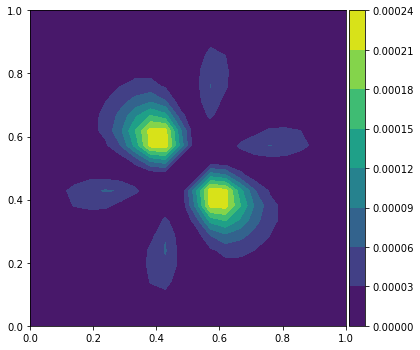

In [6]:
u_hat = eqn.solve(m)
plot_u((u_d - u_hat)**2, W)

In [7]:
def plot_ms(ms, W):
    V_coords = W.dofmap.marginal_dof_coords
    fig, ax = plt.subplots(dpi=150)
    for i, mi in enumerate(ms):
        mu_i, sig_i = np.split(mi, [m[0].function_space().dim()])
        if i==len(ms)-1: labels = [r'$\mu(x)$', r'$\sigma(x)$']
        else: labels = [None, None]
        ax.plot(V_coords, mu_i, label=labels[0], c='C0', alpha=(i+1)/len(ms))
        ax.plot(V_coords, sig_i, label=labels[1], c='C1', alpha=(i+1)/len(ms))
    plt.legend()
    ax.set_xlabel(r'x')
    plt.show()

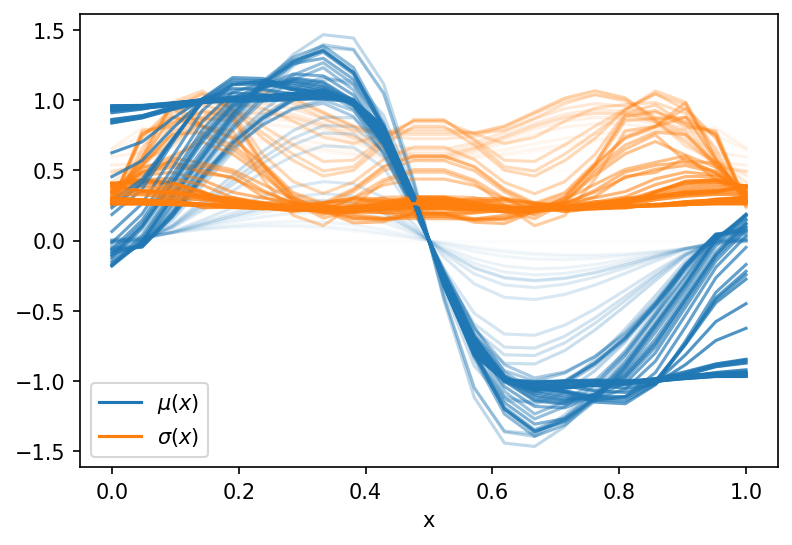

In [8]:
plot_ms(ms, W)

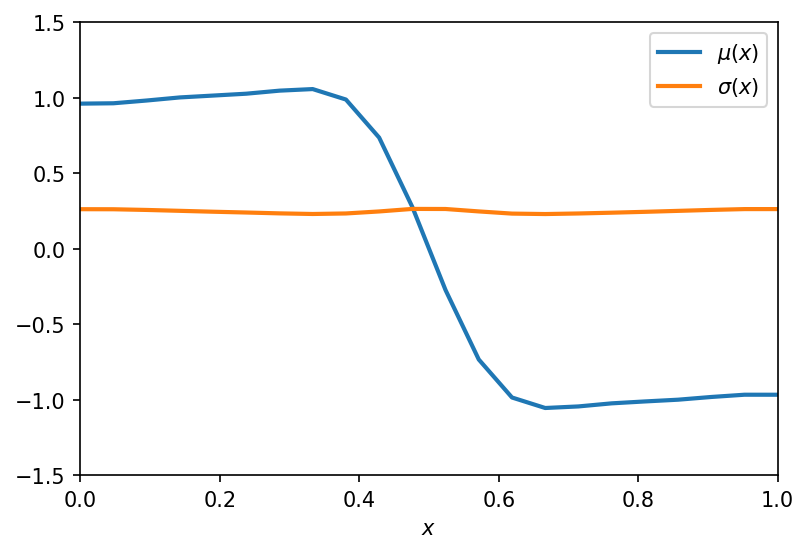

In [10]:
# creating a blank window
# for the animation
fig = plt.figure(dpi=150)
ax = plt.axes(xlim=(0, 1), ylim=(-1.5, 1.5), xlabel=r'$x$')
lines = ax.plot(np.empty((0,2)), np.empty((0,2)), lw=2, label=[r'$\mu(x)$', r'$\sigma(x)$'])
plt.legend(loc='upper right')

# animation function
def animate(i):
    mu_sig = np.split(ms[i], [mu_dim])
    for line_i, m_i in zip(lines, mu_sig):
        line_i.set_data(V_coords, m_i)
    return lines

# calling the animation function
anim = FuncAnimation(fig, animate, frames=len(ms), interval=1, blit = True)

# saves the animation in our desktop
anim.save('convergence.mp4', writer='ffmpeg', fps=10)